# BWA

In [1]:
import pysam
import matplotlib.pyplot as plt
%matplotlib inline
from Bio import SeqIO
import pandas as pd

Покрытие генома (график, процент покрытого генома, среднее покрытие)

In [2]:
def updateCover(record, cover):
    if not record.is_unmapped:
            rpos = record.reference_start
            rlen = record.reference_length
            cover[rpos] += 1
            cover[rpos + rlen] -= 1

In [3]:
def showCover(cover):
    print("Average coverage: " + str(sum(cover)/len(cover)))
    print("Coverage rate: " + str((len(cover) - cover.count(0))/len(cover)))
    avcover = [0]*(len(cover)//1000 + 1)
    x = [i for i in range(0, len(cover), 1000)]
    for i in range(len(cover)):
        avcover[i//1000] += cover[i]
    for i in range(len(avcover) - 1):
        avcover[i] /= 1000
    avcover = avcover[:-1]
    x = x[:len(avcover)]
    
    plt.plot(x, avcover)
    plt.axis([0, (len(cover)//1000 - 1)*1000, 0, max(avcover)])
    plt.xlabel('coord')
    plt.ylabel('Coverage')
    plt.show()

Статистика длин инделов.

In [4]:
def updateInDelLen(record, indelLensHist):
    if record.is_unmapped:
            return
    cigar = record.cigartuples
    for i in range(len(cigar)):
            if (cigar[i][0] == 1 or cigar[i][0] == 2):
                if (cigar[i][1] >= len(indelLensHist)):
                    indelLensHist.extend([0]*(cigar[i][1] - len(indelLensHist) + 1))
                    
                indelLensHist[cigar[i][1]] += 1
                

Статистика длин инделов в завимости от длины гомополимерного участка (участок состоящий из одного типа нуклеотидов, например АААААААА). Мы фиксируем длину гомополимерного участка (пусть 5bp), и находим все гомополимеры такой длины в референсе. Дальше смотрим как участки этой длины прочитались секвенатором. Смотрим сколько раз прочиталось 3bp, 4bp, 5bp, 6bp и итд. Повторяем это для гомополимеров всех длин (например, от 3 до 20).


In [5]:
def calculateRefHomopol(ref, refHom):
    afterCnt = [1]*len(ref)
    for i in range(1, len(ref)):
        if (ref[i] == ref[i - 1]):
            refHom[i] = refHom[i - 1] + 1
    for i in range(len(ref) - 2, 0, -1):
        if (ref[i + 1] == ref[i]):
            afterCnt[i] += afterCnt[i + 1]
    for i in range(len(ref)):
        refHom[i] += afterCnt[i]

In [6]:
def updateInDelHomopol(record, ref, refHom, inDelHomLenHist):
    if record.is_unmapped:
        return
    cigar = record.cigartuples
    rpos = record.reference_start
    seq = record.query_sequence
    seqHom = [0]*len(seq)
    calculateRefHomopol(seq, seqHom)
    spos = 0
    mxSeqHom = 1
    
    for i in range(len(cigar)):
        if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
            cntl = cigar[i][1]
            for j in range(cntl):
                if (ref[rpos + j - 1] != ref[rpos + j]):
                    inDelHomLenHist[refHom[rpos + j - 1]][mxSeqHom] += 1
                    mxSeqHom = 0
                mxSeqHom = max(mxSeqHom, seqHom[spos + j])
            rpos += cigar[i][1]
            spos += cigar[i][1]
        elif (cigar[i][0] == 1 or cigar[i][0] == 4):
            spos += cigar[i][1]
        elif (cigar[i][0] == 2 or cigar[i][0] == 3):
            cntl = cigar[i][1]
            for j in range(cntl):
                if (ref[rpos + j - 1] != ref[rpos + j]):
                    inDelHomLenHist[refHom[rpos + j - 1]][mxSeqHom] += 1
                    mxSeqHom = 0
            rpos += cigar[i][1]
    inDelHomLenHist[refHom[rpos - 1]][mxSeqHom] += 1

Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде

In [7]:
def updateQualityInsert(alig_record, read_record, qualityInsertStatistic):
    if alig_record.is_unmapped:
            return
    readpos = 0
    cigar = alig_record.cigartuples
    for i in range(len(cigar)):
        if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
            readpos += cigar[i][1]
        elif (cigar[i][0] == 1 or cigar[i][0] == 4):
            for j in range(cigar[i][1]):
                qualityInsertStatistic[read_record.letter_annotations["phred_quality"][readpos + j]] += 1
            readpos += cigar[i][1]
    

Статистика качества нуклеотидов при замене


In [8]:
def updateQualityMis(alig_record, read_record, qualityMisStatistic):
    if alig_record.is_unmapped:
            return
    readpos = 0
    cigar = alig_record.cigartuples
    for i in range(len(cigar)):
        if (cigar[i][0] == 8):
            for j in range(cigar[i][1]):
                qualityMisStatistic[read_record.letter_annotations["phred_quality"][readpos + j]] += 1
            readpos += cigar[i][1]
        elif (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 1 or cigar[i][0] == 4):
            readpos += cigar[i][1]

Таблица частот замен/вставок/удалений

In [9]:
def getLetId(c, isrv):
    #print(c)
    let = ["ACGTN", "TGCAN"]
    for i in range(5):
        if (let[isrv][i] == c):
            return i

def updateReplaceMatrix(record, ref, rmat):
        let = "ACGTN"
        if record.is_unmapped:
            return
        
        cigar = record.cigartuples
        rpos = record.reference_start
        seq = record.query_sequence
        spos = 0
        for i in range(len(cigar)):
            if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
                cntl = cigar[i][1]
                isrv = 0#record.is_reverse
                for j in range(cntl):
                    rmat[getLetId(seq[spos + j], isrv)][getLetId(ref[rpos + j], 0)] += 1
                rpos += cigar[i][1]
                spos += cigar[i][1]
            elif (cigar[i][0] == 1 or cigar[i][0] == 4):
                spos += cigar[i][1]
            elif (cigar[i][0] == 2 or cigar[i][0] == 3):
                rpos += cigar[i][1]

def drawMatrix(matrix):
    df = pd.DataFrame(data=matrix, columns=['A', 'C', 'G', 'T', 'N'], index=['A', 'C', 'G', 'T', 'N'])
    print(df)

Подсчет статистик для ридов

In [10]:
def calculateStatistic(filename, reffilename, readsfilename):
    for rec in SeqIO.parse(reffilename, "fasta"): 
        ref = rec.seq 
    
    record_dict = SeqIO.to_dict(SeqIO.parse(readsfilename, "fastq"))
    
    samfile = pysam.AlignmentFile(filename, "r")
    reflen = samfile.header.get("SQ")[0]['LN']
    
    cover = [0]*(reflen + 1)
    replaceMatrix = [[0]*5 for i in range(5)]
    inDelHomLenHist = [[0]*20 for i in range(20)]
    indelLensHist = [0]*10
    qualityInsertStatistic = [0]*66
    qualityMisStatistic = [0]*66
    refHom = [0]*len(ref)
    calculateRefHomopol(ref, refHom)
    
    for record in samfile.fetch():
        updateCover(record, cover)
        updateReplaceMatrix(record, ref, replaceMatrix)
        updateInDelLen(record, indelLensHist)
        updateQualityInsert(record, record_dict[record.query_name], qualityInsertStatistic)
        updateQualityMis(record, record_dict[record.query_name], qualityMisStatistic)
        updateInDelHomopol(record, ref, refHom, inDelHomLenHist)
        
    for i in range(1, reflen):
        cover[i] += cover[i - 1]
    return cover, replaceMatrix, indelLensHist, qualityInsertStatistic, qualityMisStatistic, inDelHomLenHist

In [11]:
def showStatistic(hist, xlabel, ylabel):
    xs = [i for i in range(0, len(hist))]
    
    plt.plot(xs, hist, 'bo')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show() 

## 1.  BWA

In [2]:
! ~/bio-project/soft/bwa-0.7.17/bwa index DH10B-K12.fasta

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.64 seconds elapse.
[bwa_index] Update BWT... 0.05 sec
[bwa_index] Pack forward-only FASTA... 0.06 sec
[bwa_index] Construct SA from BWT and Occ... 0.78 sec
[main] Version: 0.7.17-r1188
[main] CMD: /home/olga/bio-project/soft/bwa-0.7.17/bwa index DH10B-K12.fasta
[main] Real time: 3.236 sec; CPU: 2.584 sec


In [5]:
! ~/bio-project/soft/bwa-0.7.17/bwa mem DH10B-K12.fasta tst.fastq > bwa_tst.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 250 sequences (82521 bp)...
[M::mem_process_seqs] Processed 250 reads in 0.052 CPU sec, 0.056 real sec
[main] Version: 0.7.17-r1188
[main] CMD: /home/olga/bio-project/soft/bwa-0.7.17/bwa mem DH10B-K12.fasta tst.fastq
[main] Real time: 0.163 sec; CPU: 0.056 sec


In [12]:
cover, replaceMatrix, indelLensHist, qualityInsertStatistic, qualityMisStatistic, inDelHomLenHist = calculateStatistic("bwa_tst.sam", "DH10B-K12.fasta", "tst.fastq")

    * Покрытие генома

Average coverage: 0.017378702889244833
Coverage rate: 0.0005778745739028598


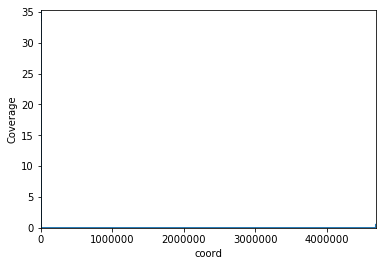

In [44]:
showCover(cover)

    * Таблица частот замен/вставок/удалений

In [45]:
drawMatrix(replaceMatrix)

       A      C      G      T  N
A  20246     10      6      7  0
C      5  20382      9      6  0
G     13      5  21166      6  0
T      7      6      3  19364  0
N      0      0      0      0  0


    * Статистика длин инделов

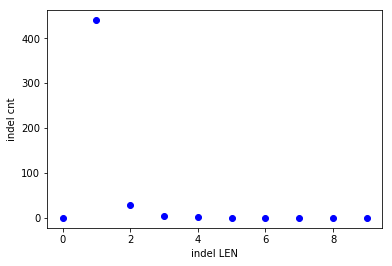

In [53]:
showStatistic(indelLensHist, 'indel LEN', 'indel cnt')

    * Статистика качества нуклеотидов при ошибки вставке нуклеотидов. 

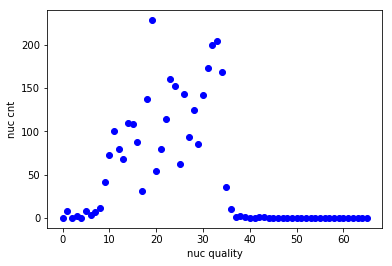

In [59]:
showStatistic(qualityInsertStatistic, 'nuc quality', 'nuc cnt')

    * Статистика качества нуклеотидов при ошибке замены. 

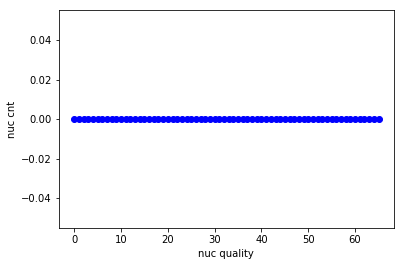

In [60]:
showStatistic(qualityMisStatistic, 'nuc quality', 'nuc cnt')

    * Статистика длин инделов в зависимости от длины гомополимерного участка. Строчки --- длина гомополимерного участка в референсе, столбцы --- в ридах. 

In [13]:
df = pd.DataFrame(data=inDelHomLenHist, columns=[i for i in range(0, 20)], index=[i for i in range(0, 20)])
print(df)

    0      1      2     3    4    5   6   7   8   9   10  11  12  13  14  15  \
0    0      0      0     0    0    0   0   0   0   0   0   0   0   0   0   0   
1   34  43013     99     7    2    1   0   0   0   0   1   0   1   0   0   0   
2    0    154  12718    43    0    0   3   0   0   0   0   0   0   0   0   0   
3    0     23     49  2328   22    0   0   0   0   0   0   0   0   0   0   0   
4    0      6      4    37  609   16   0   0   0   0   0   0   0   0   0   0   
5    0      2      1     5   44  285  13   0   0   0   0   0   0   0   0   0   
6    0      0      0     0    0   16  65   8   2   0   0   0   0   0   0   0   
7    0      0      0     0    0    1  23  22   1   1   0   0   0   0   0   0   
8    0      0      0     0    0    0   0   0   0   0   0   0   0   0   0   0   
9    0      3      0     0    1    0   1   1   1   8  11   6   3   1   0   0   
10   0      0      0     0    0    0   0   0   0   0   0   0   0   0   0   0   
11   0      0      0     0    0    0   0

## 2. Bowtie2 
Построить индекс, запустить Bowtie2 на тестовых данных, определить процент приложившихся ридов. 

In [ ]:
! bowtie2-build /Johnny/students/NGS/data/4/E.coli/MG1655-K12.first10K.fasta ecoli10K

In [3]:
! bowtie2 --fr -x ecoli10K -1 /Johnny/students/NGS/data/4/E.coli/test_1.fastq -2 /Johnny/students/NGS/data/4/E.coli/test_2.fastq > test.sam

28160 reads; of these:
  28160 (100.00%) were paired; of these:
    0 (0.00%) aligned concordantly 0 times
    28160 (100.00%) aligned concordantly exactly 1 time
    0 (0.00%) aligned concordantly >1 times
    ----
    0 pairs aligned concordantly 0 times; of these:
      0 (0.00%) aligned discordantly 1 time
    ----
    0 pairs aligned 0 times concordantly or discordantly; of these:
      0 mates make up the pairs; of these:
        0 (0.00%) aligned 0 times
        0 (0.00%) aligned exactly 1 time
        0 (0.00%) aligned >1 times
100.00% overall alignment rate


In [ ]:
! bowtie2-build /Johnny/students/NGS/data/4/E.coli/MG1655-K12.fasta ecoli

In [2]:
! bowtie2 --fr -x ecoli -1 /Johnny/students/NGS/data/4/E.coli/ecoli_mda_lane1_left.fastq.00.cor.fastq -2 /Johnny/students/NGS/data/4/E.coli/ecoli_mda_lane1_right.fastq.00.cor.fastq > ecoli_mda.sam

14196256 reads; of these:
  14196256 (100.00%) were paired; of these:
    1356988 (9.56%) aligned concordantly 0 times
    12398883 (87.34%) aligned concordantly exactly 1 time
    440385 (3.10%) aligned concordantly >1 times
    ----
    1356988 pairs aligned concordantly 0 times; of these:
      538532 (39.69%) aligned discordantly 1 time
    ----
    818456 pairs aligned 0 times concordantly or discordantly; of these:
      1636912 mates make up the pairs; of these:
        1288294 (78.70%) aligned 0 times
        297803 (18.19%) aligned exactly 1 time
        50815 (3.10%) aligned >1 times
95.46% overall alignment rate


In [4]:
! bowtie2 --fr -x ecoli -1 /Johnny/students/NGS/data/4/E.coli/s_6_1.fastq -2 /Johnny/students/NGS/data/4/E.coli/s_6_2.fastq > s6.sam

14214324 reads; of these:
  14214324 (100.00%) were paired; of these:
    121344 (0.85%) aligned concordantly 0 times
    13720474 (96.53%) aligned concordantly exactly 1 time
    372506 (2.62%) aligned concordantly >1 times
    ----
    121344 pairs aligned concordantly 0 times; of these:
      3368 (2.78%) aligned discordantly 1 time
    ----
    117976 pairs aligned 0 times concordantly or discordantly; of these:
      235952 mates make up the pairs; of these:
        144142 (61.09%) aligned 0 times
        86107 (36.49%) aligned exactly 1 time
        5703 (2.42%) aligned >1 times
99.49% overall alignment rate
